# Tutorial 1: The measpy.Signal class

The ```measpy.signal.Signal``` class describes a sampled temporal signal. It is at the core of the ```measpy.Measurement``` class, which helps in performing data acquisition.

An object of the class ```Signal``` is described by the following properties:

- A sampling frequency ```fs```
- A physical unit ```unit```
- A calibration ```cal``` in unit per Volt (if the signal comes from an DAQ acquisition)
- A multiplicative constant ```dbfs``` which express the voltage amplitude for which the acquired data equals 1 (one). This is a classical quantity when acquiring signals with audio cards, but can be ignored and kept at 1.0 with most data acquisition cards.
- A numpy array ```_rawvalues```, which corresponds to the raw data given by the digital acquisition process.
- A description ```desc``` (a string that describes the signal)

Let's first import the measpy module, as well as numpy:

In [1]:
#This is here in case we want to use the local measy directory
import sys
sys.path.insert(0, "..")

import measpy as mp
import numpy as np

## 1. Basics

Let us create a signal ```S``` with a sampling frequency of 44100 Hz.

If ```unit```, ```calibration``` and ```dbfs``` are not specified they are defaulted to dimensionless, 1.0 and 1.0 respectively. And if no content is given the samples doesn't exist and ```_rawvalues``` equals ```None```.

In [2]:
S = mp.Signal(fs=44100)
print(S)
print(S._rawvalues)

measpy.Signal(cal=1.0,dbfs=1.0,desc='A signal',unit=dimensionless,fs=44100,_rawvalues=None,)
None


As such, the above signal isn't very useful. Let us give to it some content, for instance a sinusoid at the frequency 100Hz of duration 1 second. ```raw``` property is a shortcut (@setter,@getter) for the property ```_rawvalues```.

In [3]:
S.raw = np.sin(2*np.pi*100*np.arange(0,1,1/S.fs))
S.desc = 'A sinusoidal signal at 1000Hz'
print(S.raw)
print(S._rawvalues)

[ 0.          0.0142471   0.02849132 ... -0.04272974 -0.02849132
 -0.0142471 ]
[ 0.          0.0142471   0.02849132 ... -0.04272974 -0.02849132
 -0.0142471 ]


Note that using S._rawvalues instead of S.raw would lead to the same result. More precisely the actual array is S._rawvalues, and S.raw is a shortcut (a @setter/@getter method).

Now that it contains data, the signal can be plotted.

<AxesSubplot:xlabel='Time (s)'>

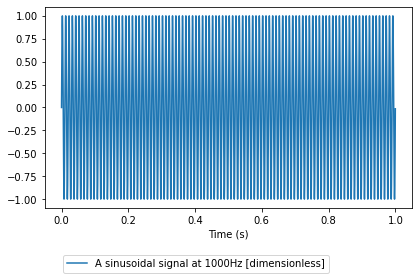

In [4]:
S.plot()

All what we have done before could be performed in one step at the initialization phase, as below.

<AxesSubplot:xlabel='Time (s)'>

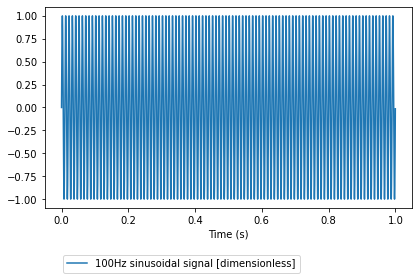

In [5]:
samplingfreq = 44100
S = mp.Signal(fs=samplingfreq,desc='100Hz sinusoidal signal',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)))
S.plot()

There is a lot of additionnal properties for the signal. For instance, the duration and the time vector. These properties are not stored in memory. When asked for, they are calculated based on the number of samples in the signal, as in the example below:

In [6]:
print(S.time)
print(S.dur)

[0.00000000e+00 2.26762512e-05 4.53525023e-05 ... 9.99954647e-01
 9.99977324e-01 1.00000000e+00]
1.0


## 2. Units

Let us now give a physical unit to this signal. Consider for instance that it is a velocity, in meter per second. In order to create such signal we have to additionnally specify the ```unit``` optionnal argument:

In [7]:
velsig = mp.Signal(fs=samplingfreq,desc='100Hz sinusoidal velocity',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),unit='m/s')

Consider a second signal, for instance a force in Newtons (N), in phase with the velocity. It is created in the same way:

In [8]:
forcesig = mp.Signal(fs=samplingfreq,desc='100Hz sinusoidal force',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),unit='N')
print(forcesig._rawvalues)

[ 0.          0.0142471   0.02849132 ... -0.04272974 -0.02849132
 -0.0142471 ]


These two signal can be multiplied together, giving an instantaneous power!

<AxesSubplot:xlabel='Time (s)'>

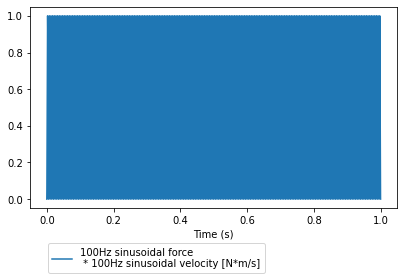

In [9]:
power = forcesig * velsig
power.plot()

Note that by default, the units are simply multiplied together. It is howver possible to ask for a standard unit of the same dimension for this signal. The below command will convert the signal to the standard unit for power (which is Watt)

In [11]:
power = power.unit_to_std()
print(power)

measpy.Signal(cal=1.0,dbfs=1.0,fs=44100,desc='100Hz sinusoidal force
 * 100Hz sinusoidal velocity
 -->Unit to W
 -->Unit to W',unit=W,_rawvalues=[0.         0.00020298 0.00081176 ... 0.00182583 0.00081176 0.00020298],)


The ```similar``` method makes a copy of the Signal object and modifies its properties specified in its arguments. Using this method, we can do the same as before and change the description at the same time.

In [12]:
power = (velsig*forcesig).unit_to_std().similar(desc='The power given to the system')
print(power)

measpy.Signal(cal=1.0,dbfs=1.0,fs=44100,desc='The power given to the system',unit=W,_rawvalues=[0.         0.00020298 0.00081176 ... 0.00182583 0.00081176 0.00020298],)


Conversely to multiplication, in order to perform an addition, the signals have to be of compatible physical units. We cannot add force and velocity! The below command should raise an ```Exception```.

In [13]:
forcesig+velsig

Exception: Incompatible units in addition of sginals

Added signals can have different dimensions if they are compatible. Let us create a signal in meter, a signal in decameter, add them, and finally plot the resulting signal.

<AxesSubplot:xlabel='Time (s)'>

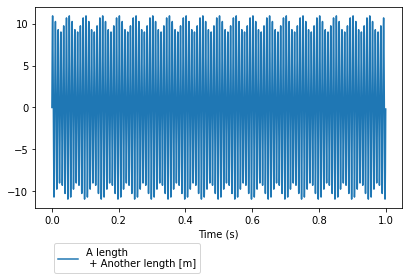

In [14]:
distance1 = mp.Signal(fs=samplingfreq,desc='A length',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),unit='m')
distance2 = mp.Signal(fs=samplingfreq,desc='Another length',raw=np.sin(2*np.pi*120*np.arange(0,1,1/samplingfreq)),unit='dam')
distancetot = distance1+distance2
distancetot.plot()

When performing addition of signals, the final unit is that of the first operand. That's why we get meters in the above calculation. If we switch the signals, we get the same thing, but in decameters...

<AxesSubplot:xlabel='Time (s)'>

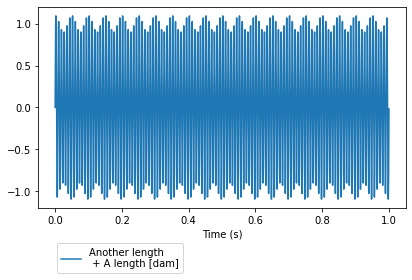

In [15]:
distancetot = distance2+distance1
distancetot.plot()

We might want to convert this to millimeters... There is a method for that.

<AxesSubplot:xlabel='Time (s)'>

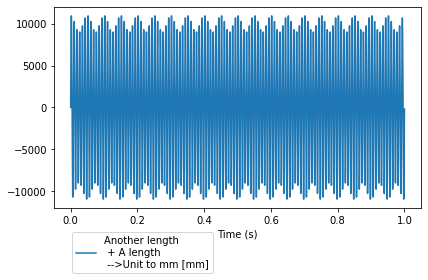

In [16]:
distancetot.unit_to('mm').plot()

Any operation on signals necessitates that the operands are signals of same length and frequency. For instance, consider a for signal of different sampling frequency, and try to add it to the previous force signal. This should give us an error.

In [17]:
samplingfreq2=48000
forcesig2 = mp.Signal(fs=samplingfreq2,desc='100Hz sinusoidal force at fs=48000Hz',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq2)),unit='N')
forcetot = forcesig+forcesig2

Exception: Incompatible sampling frequencies in addition of signals

But we can try to resample one signal to match the sampling frequency of the orther. If the two signals are of same length after one is resampled to match the other, this will work...

<AxesSubplot:xlabel='Time (s)'>

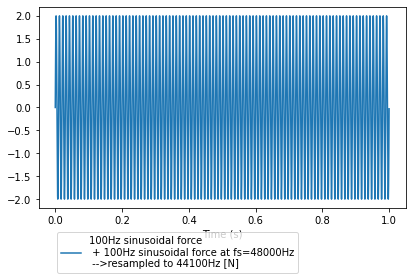

In [19]:
forcetot = forcesig+forcesig2.resample(forcesig.fs)
forcetot.plot()

## 3. Calibrations

Up to now, we didn't care about calibration. In fact, if we worked only with such synthesized signal, there wouldn't be any reason to.

Most of the time, these signals come from data acquisition process, where an accelerometer, a force/torque sensor, a microphone or an optical velocity measurement device is involved.

Conditionners generally produce a voltage signal that is proportionnal to the measured quantity. The calibration ```cal``` is hence a float number which in expressed in Volts/units.

The data acquisition device the captures this voltage signal at a given sampling frequency. If the acquired samples directly express the voltage input, ```dbfs=1```. With some devices (for instance line inputs of sound cards), the acquired sample values are proportionnal, but not equal. The coefficient of proportionnality is ```dbfs```.

The true signal expressed in unit is hence given by multiplying the ```_rawvalues``` property by dbfs (to convert it in volts) and dividing the resulting array by ```cal```.

There are methods for that.


Consider the signal below. A sinusoidal velocity. The calibration was 2V/(m/s) and the input measures 1.0 when there is 5 incoming Volts.

In [20]:
velsig = mp.Signal(fs=samplingfreq,
    desc='100Hz sinusoidal velocity',
    raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),
    unit='m/s',
    cal=2.0,
    dbfs=5.0)

The raw values given by the sound card are accessed by using the ```_rawvalues``` property or ```raw```, which is a shortcut method, and is preferrable.

In [21]:
velsig.raw

array([ 0.        ,  0.0142471 ,  0.02849132, ..., -0.04272974,
       -0.02849132, -0.0142471 ])

We might want for some reason the actual voltage that was going into the daq card.

In [22]:
velsig.volts

array([ 0.        ,  0.07123552,  0.14245658, ..., -0.21364872,
       -0.14245658, -0.07123552])

The measured values in m/s are accessed using the ```values``` property... And this is what is plotted when we use the ```velsig.plot()``` method.

[ 0.          0.03561776  0.07122829 ... -0.10682436 -0.07122829
 -0.03561776]


<AxesSubplot:xlabel='Time (s)'>

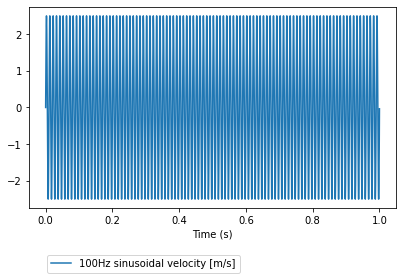

In [23]:
print(velsig.values)
velsig.plot()

## 4. File I/O

The preferred format for saving a ```Signal``` object is a combination of a CSV file for the properties and a WAV file for the data. Simply use the method ```to_csvwav```, which takes a string as argument.

In [24]:
velsig.to_csvwav('velocity')

The above command creates the files velocity.csv and velocity.wav.

To load it again, use the @classmethod ```from_csvwav```, as below:

<AxesSubplot:xlabel='Time (s)'>

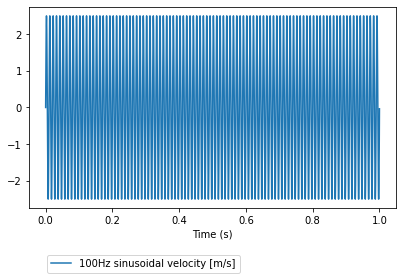

In [25]:
vel = mp.Signal.from_csvwav('velocity')
vel.plot()

There is also a ```from_wav``` @classmethod which allows to import a WAV file. As only the data and the sampling frequency are stored in a WAV file, the other properties have to be specified as optionnal named parameters if necessary (unit,calibrations, etc.)

In [26]:
vel = mp.Signal.from_wav('velocity.wav',unit='m/s',desc='This is a velocity')